# Let's do some experiements on real data: Time-Series Predictions

### Time-Series
* Data measured against points in time. We can do forecasting, interpolation, extrapolation, corelation, analysis, etc...

### About data
* Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming


### Contents
* Daily average temperature values(°F)

### Data-Preprocessing- Dr. Willi Rath
### Prepare data
* The data is in a compressed csv file. We first need to unzip it:

### Technical preamble

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualization

## Read data

The data is in a compressed csv file. We first need to unzip it:

In [2]:
!(cd data/ && unzip -o city_temperature.csv.zip)
!cat data/city_temperature/licence

Archive:  city_temperature.csv.zip
  inflating: city_temperature/city_temperature.csv  
  inflating: city_temperature/licence  
==== city_temperature.csv ====

This CSV file was downloaded from https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities on 2020-11-17.

The original data were assembled by Sudalai Rajkumar (https://www.kaggle.com/sudalairajkumar) from data provided by the University of Dayton (http://academic.udayton.edu/kissock/http/Weather/default.htm).

In [3]:
df = pd.read_csv('data/city_temperature/city_temperature.csv')

/home/sonal/anaconda3/envs/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
display(df)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [5]:
df = df.iloc[:3650] #selecting few_data
df = df[["Year", "Month", "Day", "AvgTemperature"]]
df

,Year,Month,Day,AvgTemperature
0,1995,1,1,64.2
1,1995,1,2,49.4
2,1995,1,3,48.8
3,1995,1,4,46.4
4,1995,1,5,47.9
...,...,...,...,...
3645,2004,12,24,46.6
3646,2004,12,25,52.4
3647,2004,12,26,47.4
3648,2004,12,27,44.9


### Use real timesteps
* There seem to be a few time stamps that are wrong. Let's just replace them with `NaT`("Not A Time")

In [6]:
#If ‘coerce’, then invalid parsing will be set as NaT
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]], errors='coerce')

In [7]:
display(df)

,Year,Month,Day,AvgTemperature,Date
0,1995,1,1,64.2,1995-01-01
1,1995,1,2,49.4,1995-01-02
2,1995,1,3,48.8,1995-01-03
3,1995,1,4,46.4,1995-01-04
4,1995,1,5,47.9,1995-01-05
...,...,...,...,...,...
3645,2004,12,24,46.6,2004-12-24
3646,2004,12,25,52.4,2004-12-25
3647,2004,12,26,47.4,2004-12-26
3648,2004,12,27,44.9,2004-12-27


In [8]:
df = df[["Date", "AvgTemperature"]]
df

,Date,AvgTemperature
0,1995-01-01,64.2
1,1995-01-02,49.4
2,1995-01-03,48.8
3,1995-01-04,46.4
4,1995-01-05,47.9
...,...,...
3645,2004-12-24,46.6
3646,2004-12-25,52.4
3647,2004-12-26,47.4
3648,2004-12-27,44.9


### Have a look at temperature

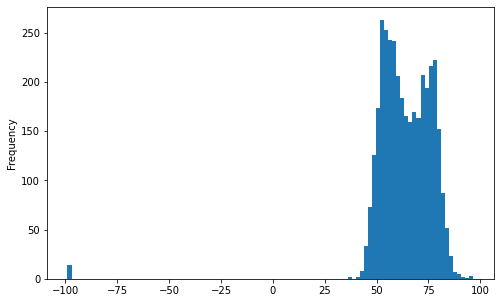

In [9]:
df.AvgTemperature.plot.hist(bins=100, figsize=(8, 5));

In [10]:
df.AvgTemperature.describe()

count    3650.000000
mean       63.782767
std        14.624069
min       -99.000000
25%        55.300000
50%        63.400000
75%        73.600000
max        96.600000
Name: AvgTemperature, dtype: float64

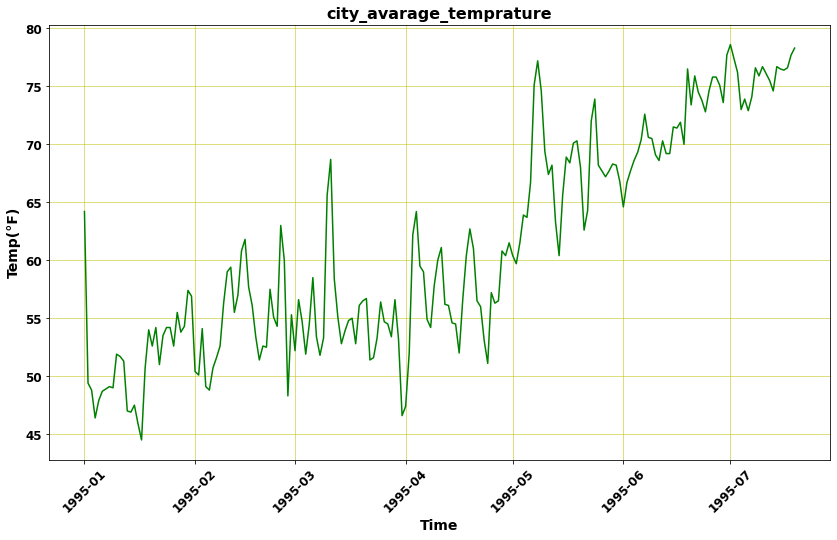

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(14, 8))
plt.plot(df.Date[:200], df.AvgTemperature[0:200], color='g')
plt.title('city_avarage_temprature', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Temp(°F)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

### Features Extraction
* past 15 values as inputs with the value at any corresponding time instant
* this means we will have additional 15 columns as features 
   * where each row will have temp at any day and the corresponding temp of past 15 days

In [12]:
def create_features(df, attribute, features_prev_list):
    features_prev_list.sort()
    start = features_prev_list[-1] #15
    end = len(df) #3650
 
    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            e_df = pd.DataFrame() #empty_dataframe

            for prev_t in features_prev_list :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                e_df = pd.concat([e_df, new_col], sort=False, axis=1)
                #print('s:',start-prev_t)
                #print('e:',end-prev_t)
            df_copy = pd.concat([df_copy, e_df], sort=False, axis=1)
            
    return df_copy

In [13]:
feature_list = ['AvgTemperature']

features_prev_list = []
for i in range(1,16):
    features_prev_list.append(i)

features_prev_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [14]:
df_new = create_features(df, feature_list, features_prev_list)
df_new

,Date,AvgTemperature,AvgTemperature_(t-1),AvgTemperature_(t-2),AvgTemperature_(t-3),AvgTemperature_(t-4),AvgTemperature_(t-5),AvgTemperature_(t-6),AvgTemperature_(t-7),AvgTemperature_(t-8),AvgTemperature_(t-9),AvgTemperature_(t-10),AvgTemperature_(t-11),AvgTemperature_(t-12),AvgTemperature_(t-13),AvgTemperature_(t-14),AvgTemperature_(t-15)
0,1995-01-16,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4,64.2
1,1995-01-17,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4
2,1995-01-18,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8
3,1995-01-19,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4
4,1995-01-20,52.6,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,2004-12-24,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6,53.2
3631,2004-12-25,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6
3632,2004-12-26,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4
3633,2004-12-27,44.9,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8


In [15]:
df_new = df_new.drop(columns=["Date", ])
df_new

,AvgTemperature,AvgTemperature_(t-1),AvgTemperature_(t-2),AvgTemperature_(t-3),AvgTemperature_(t-4),AvgTemperature_(t-5),AvgTemperature_(t-6),AvgTemperature_(t-7),AvgTemperature_(t-8),AvgTemperature_(t-9),AvgTemperature_(t-10),AvgTemperature_(t-11),AvgTemperature_(t-12),AvgTemperature_(t-13),AvgTemperature_(t-14),AvgTemperature_(t-15)
0,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4,64.2
1,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4
2,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8
3,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4
4,52.6,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6,53.2
3631,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6
3632,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4
3633,44.9,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8


### Building_Neural_Network_model

In [16]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


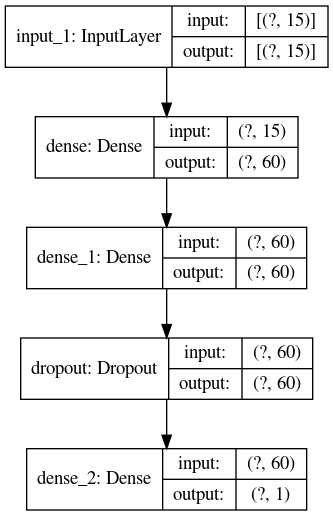

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

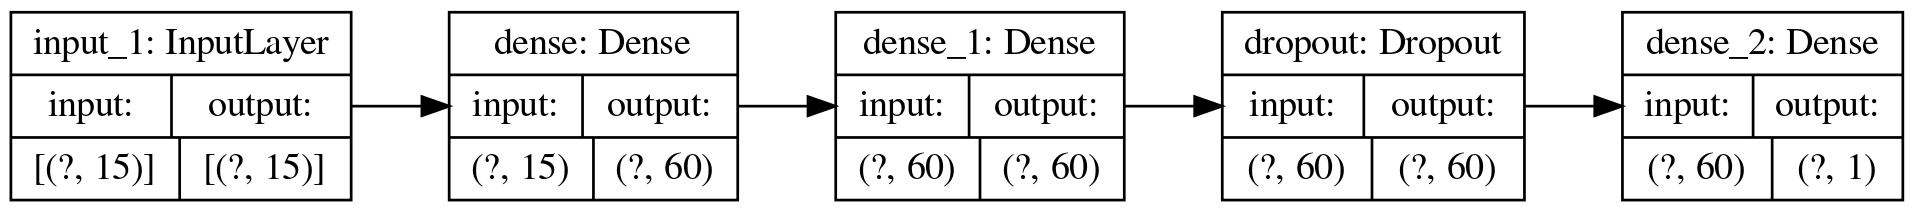

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR", #'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=196,
)

In [20]:
#75% training and 25% testing

from sklearn.model_selection import train_test_split

df_copy = df_new.reset_index(drop=True)

x_features = df_copy.iloc[:, 1:] #2 to 16 columns (avgtemp(t-1) to avgtemp(t-15))
y_label = df_copy.iloc[:,0] #1st column as label, predicting actual temp

xtrain, xtest, ytrain, ytest=train_test_split(x_features, y_label, test_size=0.25)


print('Shape of features and label:', x_features.shape, y_label.shape)
print('Shape of xtrain and ytrain:', xtrain.shape, ytrain.shape)
print('Shape of xtest and ytest:', xtest.shape, ytest.shape)

Shape of features and label: (3635, 15) (3635,)
Shape of xtrain and ytrain: (2726, 15) (2726,)
Shape of xtest and ytest: (909, 15) (909,)


### Scaling the data
* Normalize data in the range in the range (0.01, 0.99) before feeding it to the the neural network
* MinMaxScaler() function takes in dataframes or series (can also take in arrays), but it always returns n-dimensional arrays.

In [21]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(xtrain))
X_test_scaled = Feature_scaler.fit_transform(np.array(xtest))

y_train_scaled = Target_scaler.fit_transform(np.array(ytrain).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(ytest).reshape(-1,1))

In [40]:
model.fit(X_train_scaled,y_train_scaled,
    batch_size=256, epochs=10, verbose=1)

Epoch 1/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 3/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 10/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0055


In [41]:
y_test_pred = model.predict(X_test_scaled)

In [42]:
#inverse_transform
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)

y_test_pred_rescaled = Target_scaler.inverse_transform(y_test_pred)


In [43]:
y_test_rescaled.shape

(909, 1)

In [44]:
y_test_pred_rescaled.shape

(909, 1)

In [45]:
from sklearn.metrics import mean_squared_error
mse_test_model=mean_squared_error(y_test_scaled, y_test_pred)
print('test_mse of NN:', mse_test_model)

test_mse of NN: 0.0026425977099009423


In [46]:
from sklearn.metrics import r2_score

score = r2_score(y_test_rescaled, y_test_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.3816


In [47]:
y_test_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Temperature'])
y_test_hat = pd.DataFrame(y_test_pred_rescaled, columns=['Predicted Temperature'])

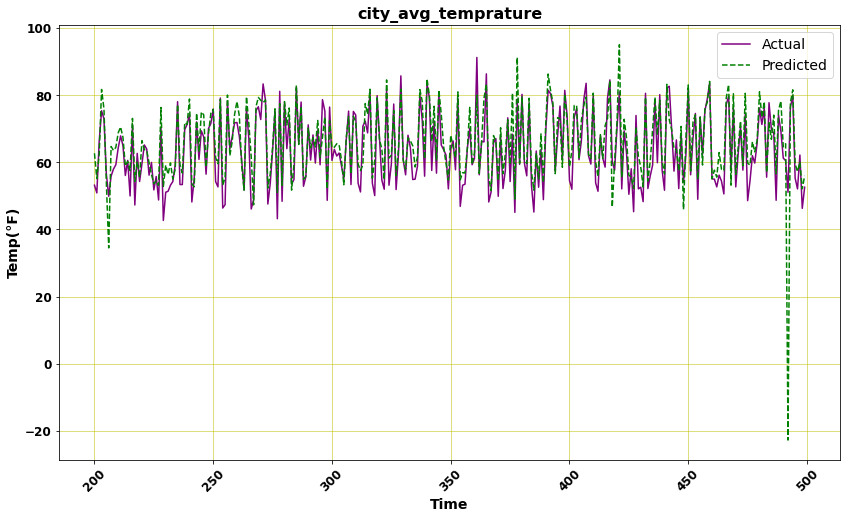

In [48]:
#Test_samples
plt.figure(figsize=(14, 8))
plt.plot(y_test_actual[200:500], linestyle='solid', color='purple')
plt.plot(y_test_hat[200:500], linestyle='dashed', color='green')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('city_avg_temprature', weight='bold', fontsize=16)
plt.ylabel('Temp(°F)', weight='bold', fontsize=14)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Take-home-point: Ecosystem: An easier way

* If you are not familiar at installing software on your machine, there is an easier option: Anaconda_Distribution
* It supports the three main platforms of Microsoft Windows, Mac OS X and Linux
* It includes Python, SciPy and scikit-learn. Everything you need to learn, practice and use machine learning with the Python Environment